In [16]:
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

# Models of causal exposure and identification criteria for conditioning estimators

### Introduction

**Approaches to the estimation of causal effects**

* conditioning on variable that block all back-door paths from the causal variable to the outcome variable

* using exogenous variation in an appropriate instrumental variable to isolate covariation in the causal variable and the outcome variable

* establishing the exhaustive and isolated mechanism that intercepts the effect of the causal variable on the outcome variable and then calculating the causal effect as it propagates through the mechanisms

### Conditioning and directed graphs

<img src="material/fig-backdoor-path.png" width="300" />

This graph is an example where a simple mean-comparison between the treated and untreated is not informative on the effect of the treatment.
Why?

* The total association between $D$ and $Y$ is an unknown composite of the true causal effect $D \rightarrow Y$ and the noncausal association between $D$ and $Y$.

**Conditioning strategies**

* balancing the determinants of treatment assignment (e.g. matching estimators)

* adjusting for all other causes of the outcome (e.g. regression estimators)

**Small excourse -  Matching estimators**

A challenge with many observational studies for obtaining causal effect is self-selection — in many cases, people choose to receive treatment for some reasons, and consequently, the treated people cannot be directly compared with the untreated people. For instance, students from rich families might be more likely to choose to attend private college. If we wish to know the causal effect of attending private college on earnings, we shall rule out (or control) the effect of family background.
Matching estimator has been widely used across disciplines. It is a quasi-experimental method that aims to search for counterfactual unit that is comparable with the treated unit among many untreated units.


**Back-door path**

A back-door path is a path between any causally ordered sequence of two variables that begins with a directed edge that points to the first variable.


**LaLonde dataset**

What was the graph behind our analysis of the Lalonde dataset?

<img src="material/fig-implicit-lalonde.png" width="500" />

#### Illustration of collider variables

#### Small recap - collider variable

* A variable is a collider when it is causally influenced by two or more variables.

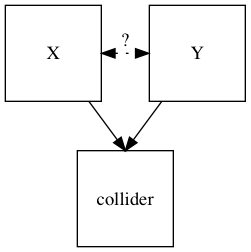
* The result of having a collider in the path is that the collider blocks the association between the variables that influence it.
* A collider does not generate an unconditional association between the variables that determine it.
* In causal graphs, conditioning on the collider opens the path between X and Y. This will introduce bias when estimating the causal association between X and Y, potentially introducing associations where there are none.


They will play a very important role going forward and thus we study in an illustration how conditioning on a **collider** induces a conditional association between two variables without an unconditional association.

<img src="material/fig-collider-variable.png" width="500" />

### Pearsons correlation coefficient

* Pearson's correlation coefficient is the covariance of the two variables divided by the product of their standard deviations. 
* As with covariance itself, the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation. 
* As a simple example, one would expect the age and height of a sample of teenagers from a high school to have a Pearson correlation coefficient significantly greater than 0, but less than 1 (as 1 would represent an unrealistically perfect correlation).

In [17]:
num_individuals = 250

# Initialize empty data frame
columns = ["SAT", "motivation", "admission"]
df = pd.DataFrame(columns=columns, index=range(num_individuals))

df["motivation"] = np.random.normal(size=num_individuals)
df["SAT"] = np.random.normal(size=num_individuals)

# Both toghether determine college admission
score = df["motivation"] + df["SAT"]
cutoff = np.percentile(df["motivation"] + df["SAT"], 85)
df["admission"] = score > cutoff
df.head()

,SAT,motivation,admission
0,-0.555981,-0.097208,False
1,-0.207885,0.420932,False
2,-0.554067,-0.503342,False
3,-0.777587,1.861293,False
4,-0.345035,-0.218781,False


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The Pearson correlation coefficient is  -0.029


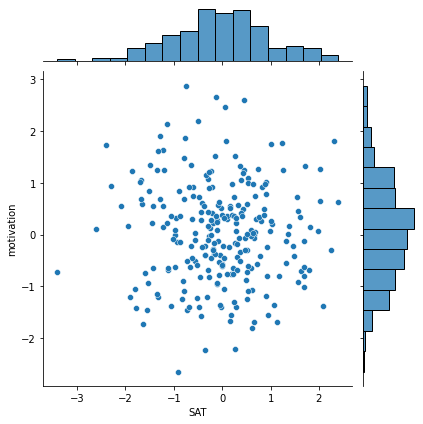

In [18]:
def get_joint_distribution(df):
    sns.jointplot("SAT", "motivation", data = df)

    stat = stats.pearsonr(df["SAT"], df["motivation"])[0]
    print(f"The Pearson correlation coefficient is {stat:7.3f}")


get_joint_distribution(df)

What happens if we condition on college admittance $C$, i.e. on a collider variable?

In the following we are conditioning on admission == True, so we are just looking at the indicidauls that got admission and will see how the joint distribution of SAT and motivation looks like:

In [19]:
df.query("admission == True").head(5)

# askes the columns of a df with a boolean variable

,SAT,motivation,admission
5,0.445693,2.603001,True
6,2.319592,1.810582,True
17,-0.136591,2.662586,True
21,1.251576,1.242540,True
29,0.531382,1.089082,True


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The Pearson correlation coefficient is  -0.671


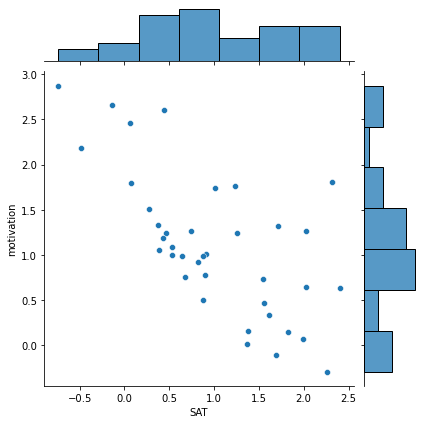

In [20]:
get_joint_distribution(df.query("admission == True"))

From the Graph, we can clearly follow:
* Conditioning on a collider variable that lies along a back-door path does not help to block the back-door path but instead creates new associations.
* Here, it creates a strong negative correlation between motivation and SAT score

### The back-door criterion

The **back-door** criterion allows to determine to whether or not conditioning on a given set of observed variables (Z) will identify the causal effect of interest.  


* **Step 1** Write down the back-door paths from the causal variable to the outcome variable, determine which ones are unblocked, and then search for a candidate conditioning set of observed variables that will block all unblocked back-door paths.

* **Step 2** If a candidate conditioning set is found that blocks all back-door paths, inspect the patterns of decent in the graph in order to verify that the variables in the candidate conditioning set do not block or otherwise adjust away any portion of the causal effect of interest.


If one or more back-door paths connect the causal variable to the outcome variable, the causal effect is identified by conditioning on a set of variables $Z$ if 

**Condition 1:** All back-door paths between the causal variable and the outcome variable are blocked after conditioning on $Z$, which will always be the case if each back-door path

* contains a chain of mediation $A\rightarrow C \rightarrow B$ where the middle variable $C$ is in $Z$ 

* contains a fork of mutual dependence $A \leftarrow C \rightarrow B$, where the middle variable $C$ is in $Z$

* contains an inverted fork of mutual causation $A \rightarrow C \leftarrow B$, where the middle variable $C$ and all of $C$'s decendents are **not** in $Z$

and ...



**Condition 2:** No variables in $Z$ are decendents of the causal variable that lie on (or decend from other variables that lie on) any of the directed paths that begin at the causal variable and reach the outcome variable.

Let's revisit our example earlier:

<img src="material/fig-backdoor-path.png" width="300" />


Here we have a
* chain of mediation between C -> O -> Y
* fork of mutual dependence from the node C

Here we could condition on C or on O


We will now work through two more advanced examples where we focus on only the first conditions of the back-door criterion.

* Let's start with a simple example and apply the idea of back-door identification to a graph where we consider conditioning on a lagged outcome variable $Y_{t -1}$.

<img src="material/fig-backdoor-example-1.png" width="500" />

* $Y_{t - 1}$ lies on both back-door paths but it does not satisfy the back-door criterion. It blocks one path, but is a collider variable (inverted fork of mutual causation) on the other

Let us practice our understanding for some interesting graph structures. The backdoor algorithm is also available [here](https://nbviewer.jupyter.org/github/HumanCapitalAnalysis/microeconometrics/blob/master/lectures/04_criteria_conditioning_estimators/back_door_algorithm.ipynb) for your reference.

Here are a couple of candidates conditioning sets.

* $\{F\}$
* This will work, since it is a node in a chain of mediation
* $\{A\}$
* Does not work! Since A is a inverted fork of mutual causation
* $\{A, B\}$
* Does work! Since we are using A as an node of a chain of mediation between V and D and B also as the node between U and D

<img src="material/fig-backdoor-example-2.png" width="500" />

Finally, let's focus on the second condition.

* **Condition 2:** No variables in $Z$ are decendents of the causal variable that lie on (or decend from other variables that lie on) any of the directed paths that begin at the causal variable and reach the outcome variable.

We first look at a graph that illustrates what a descendent is and remind ourselves of the difference between a direct and an indirect effect.

<img src="material/fig-backdoor-indirect-effect.png" width="300" />

Conditioning on $N$ (in addition to either $N$ or $O$) does not satisfy the back-door criterion due to its violation of the second condition.

Let's evaluate the following conditioning set: $\{O, B\}$.

<img src="material/fig-backdoor-condition-2.png" width="300" />

We can also build our own causal graphs using http://www.dagitty.net!

### Models of causal exposure and point identification based on potential outcome model

#### Treatment assignment modeling in statistics

Treatment assignment patterns are represented by a general conditional probability distribution often referred to as propensity scores:

The propensity score is the probability of treatment assignment conditional on observed baseline characteristics. The propensity score allows one to design and analyze an observational (nonrandomized) study so that it mimics some of the particular characteristics of a randomized controlled trial.

\begin{align*}
\Pr[D = 1 \mid S], 
\end{align*}

where $S$ denotes all variables that systematically determine treatment assignment (baseline characteristics).

* In the case of a randomized experiment we know the propensity score, while we have to estimate it in observational studies.


If all variables in $S$ are observed, then treatment assignment is ignorable
\begin{align*}
(Y^0, Y^1) \perp \!\!\! \perp D \mid S 
\end{align*}

Within the strata(=Schichten) defined by $S$, the remaining variation in $D$ is random  and hence the process that generates these remaining variations is ignorable.

**Strategy to ensure ignorable treatment assignment**

* determine from related studies and supportable assumptions grounded in theory what the components of $S$ are

* measure each of the components in $S$

* collect enough data to be able to considerably estimate outcome differences on the observed variable $Y$ within strata defined by $S$

<img src="material/fig-assignment-statistics.png" width="500" />

#### Treatment selection modeling in econometrics

\begin{align*}
Y & = D Y^1 + (1 - D) Y^0 \\
& = Y^0 + D(Y^1 - Y^0) \\
& = Y^0 + \delta D \\
& = \mu^0 + \delta D + \nu^0,
\end{align*}

where $\mu^0 \equiv E[Y^0]$ and $\nu^0 \equiv Y^0 - E[Y^0]$.

Let's emphasize potential treatment effect heterogeneity:

\begin{align*}
Y = \mu^0 + ( \mu^1 - \mu^0) D + \{\nu^0 + D(\nu^1 - \nu^0)\}
\end{align*}
where $\mu^1 \equiv E[Y^1]$ and $\nu^1 \equiv Y^1 - E[Y^1]$.

Let's introduce a latent variable to be more precise about the 

\begin{align*}
\tilde{D} = Z\phi + U, 
\end{align*}

where $U$ contains systematic unobserved determinants of treatment selection and completely random components.

The latent continuous variable $D$ is then related to our treatment selection dummy as follows.

\begin{align*}
D = \begin{cases}
1 & \quad\text{if}\quad \tilde{D} > 0 \\
0 & \quad\text{otherwise}
\end{cases}
\end{align*}


**Selection on observables and unobservables**

<img src="material/fig-assignment-econometrics.png" width="500" />

Link to the literature on treatment assignment in statistics:

* $Z$ equals $S$  $\rightarrow$ selection on observables
* $Z$ is only a subset of $S$ $\rightarrow$ selection on unobservables